# Imports and Setup

In [1]:
# heavy imports

from diffusers import AutoencoderKL
from diffusers import DDPMScheduler
from diffusers import StableDiffusionPipeline
from diffusers import UNet2DConditionModel

In [16]:
import os
import math
import random
import json
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from typing import Optional
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.transforms import functional as TF
from datasets import load_dataset, Dataset

from transformers import CLIPTextModel, CLIPTokenizer
from transformers import get_constant_schedule_with_warmup

In [3]:
# setup

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# check if gpus are available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# gpu details: preferred A100 with 256 GBs
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB


# Configurations

In [7]:
# model paths
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"  # base model
output_dir = "./fashion-model-finetuned"  # where to save the model

# dataset parameters
base_dir = 'data/DFMM-Spotlight/'  # data path
image_column = "image"  # column name containing images
caption_column = "text"  # column name containing captions
train_images_dir = os.path.join(base_dir, "train_images")
mask_dir = os.path.join(base_dir, "mask")
ann_file = os.path.join(base_dir, "mask_ann", "train_ann_file.jsonl")

# training parameters
resolution = 512  # image resolution for training
train_batch_size = 4  # adjust based on your gpu memory
num_train_epochs = 10  # number of training epochs
max_train_steps = None  # if set, overrides num_train_epochs
gradient_accumulation_steps = 1  # for effective larger batch size
learning_rate = 1e-5  # training learning rate
lr_scheduler = "constant"  # learning rate scheduler type
lr_warmup_steps = 0  # warmup steps for learning rate
adam_beta1 = 0.9  # adam optimizer beta1
adam_beta2 = 0.999  # adam optimizer beta2
adam_weight_decay = 1e-2  # weight decay for regularization
adam_epsilon = 1e-08  # small epsilon for numerical stability
max_grad_norm = 1.0  # gradient clipping norm
checkpointing_steps = 500  # save checkpoint every n steps

In [5]:
# Print number of data points

with open(base_dir + 'mask_ann/train_ann_file.jsonl', 'r') as file:
    line_count_train = sum(1 for line in file)
        
with open(base_dir + 'mask_ann/test_ann_file.jsonl', 'r') as file:
    line_count_test = sum(1 for line in file)

print("Number of train images: ", len(os.listdir(base_dir + 'train_images')))
print("Number of test images: ", len(os.listdir(base_dir + 'test_images')))
print("Number of image masks: ", len(os.listdir(base_dir + 'mask')))
print("Number of data points in train set: ", line_count_train)
print("Number of data points in test set: ", line_count_test)

Number of train images:  10335
Number of test images:  1149
Number of image masks:  23756
Number of data points in train set:  21377
Number of data points in test set:  2379


# Load Models

In [6]:
# noise scheduler for the diffusion process
noise_scheduler = DDPMScheduler.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="scheduler"
)

# tokenizer for processing text prompts
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="tokenizer"
)

# text encoder to convert text to embeddings
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="text_encoder"
)

# vae model for encoding images to latent space and vice versa
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, 
    subfolder="vae"
)

# unet model - the part we'll be fine-tuning
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path,
    low_cpu_mem_usage=False, 
    ignore_mismatched_sizes=True,
    in_channels=9,  # modified for mask and masked image
    subfolder="unet"
)

# move models to device (gpu if available)
text_encoder = text_encoder.to(device)
vae = vae.to(device)
unet = unet.to(device)

# freeze vae and text encoder - we only want to train the UNet
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

# print model parameters information
print(f"UNet parameters to be trained: {sum(p.numel() for p in unet.parameters() if p.requires_grad)}")

/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of UNet2DConditionModel were not initialized from the model checkpoint at runwayml/stable-diffusion-v1-5 and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 9, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


UNet parameters to be trained: 859535364


# Dataset Preparation

The dataset needs to include images, text prompts, and masks:
- Images: The fashion items/outfits
- Text: Descriptions of the desired edits
- Masks: Binary masks identifying regions to edit

**Dataset Format Requirements**

Dataset Type: The code expects a HuggingFace dataset that can be loaded with load_dataset()

**Required Columns**

- image: Contains image data
- text: Contains the caption/description for each image
- mask: Contains segmentation masks for each image

**Image Format**

- The images should be convertible to RGB format with .convert("RGB")
- Typically these would be PIL Image objects
- The image dimensions can vary as they get resized during preprocessing

**Mask Format**

- Should be compatible with torchvision transforms
- Typically a grayscale image where pixel values indicate which area to mask
- Will be converted to a binary mask (0/1 values)

**Text Format**

- A string containing the caption
- A list/array of strings (from which one will be randomly selected)

**Example**

```
{
    "image": <PIL.Image object>,       # RGB image
    "mask": <PIL.Image object>,        # Grayscale/binary mask
    "text": "Description of the image"  # or ["caption1", "caption2", ...]
}
```

In [11]:
# Load the annotation lines
with open(ann_file, "r") as f:
    lines = [json.loads(line.strip()) for line in f]

# Create data entries with full paths and loadable objects
data = []
for entry in tqdm(lines):
    image_path = os.path.join(train_images_dir, entry["image"])
    mask_path = os.path.join(mask_dir, entry["mask"])
    
    if os.path.exists(image_path) and os.path.exists(mask_path):
        data.append({
            "image_path": image_path,
            "mask_path": mask_path,
            "image": Image.open(image_path),
            "mask": Image.open(mask_path),
            "text": entry["text"]
        })
    else:
        print(f"Missing file for {entry['image']} or {entry['mask']}")

# Create HuggingFace dataset
train_dataset = Dataset.from_list(data)

print(train_dataset)

  0%|          | 0/21377 [00:00<?, ?it/s]

Dataset({
    features: ['image_path', 'mask_path', 'image', 'mask', 'text'],
    num_rows: 21377
})


In [13]:
def joint_transform(image, mask, resolution):
    # Resize image and mask
    image = TF.resize(image, size=(resolution, resolution // 2), interpolation=TF.InterpolationMode.BILINEAR)
    mask = TF.resize(mask, size=(resolution, resolution // 2), interpolation=TF.InterpolationMode.NEAREST)

    # Center crop both
    image = TF.center_crop(image, output_size=[resolution, resolution])
    mask = TF.center_crop(mask, output_size=[resolution, resolution])

    # Random horizontal flip
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # To tensor
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.5], [0.5])
    mask = TF.to_tensor(mask)

    return image, mask

In [14]:
# preprocessing function
def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]  # convert images to RGB format
    masks = [mask for mask in examples['mask']]  # extract masks (assumes dataset has a 'mask' column)
    
    examples["pixel_values"] = []
    examples["pixel_mask_values"] = []

    for img, mask in zip(images, masks):
        img_t, mask_t = joint_transform(img, mask, resolution)
        examples["pixel_values"].append(img_t)
        examples["pixel_mask_values"].append(mask_t)
    
    # create masked pixel values by applying mask to image
    examples["masked_pixel_values"] = [
        torch.masked_fill(
            examples["pixel_values"][i], 
            examples["pixel_mask_values"][i].bool(), 
            0
        ) for i in range(len(images))
    ]
    
    # tokenize the captions
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            captions.append(random.choice(caption))
        else:
            raise ValueError("Caption column should contain strings or lists of strings.")
            
    inputs = tokenizer(
        captions, 
        max_length=tokenizer.model_max_length, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    )
    examples["input_ids"] = inputs.input_ids
    
    return examples

# apply preprocessing to the dataset
train_dataset = train_dataset.with_transform(preprocess_train)

Parameter 'transform'=<function preprocess_train at 0x7f4ebe5d04c0> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [15]:
# collate function for the dataloader
def collate_fn(examples):
    # stack the tensors
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()    
    pixel_mask_values = torch.stack([example["pixel_mask_values"] for example in examples])
    pixel_mask_values = pixel_mask_values.to(memory_format=torch.contiguous_format)
    masked_pixel_values = torch.stack([example["masked_pixel_values"] for example in examples])
    masked_pixel_values = masked_pixel_values.to(memory_format=torch.contiguous_format).float()
    
    # stack the tokenized text
    input_ids = torch.stack([example["input_ids"] for example in examples])
    
    return {
        "pixel_values": pixel_values, 
        "pixel_mask_values": pixel_mask_values,
        "masked_pixel_values": masked_pixel_values, 
        "input_ids": input_ids
    }

# create DataLoader for training
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
    num_workers=2,  # adjust based on your CPU (can be found out using os.cpu_count())
)

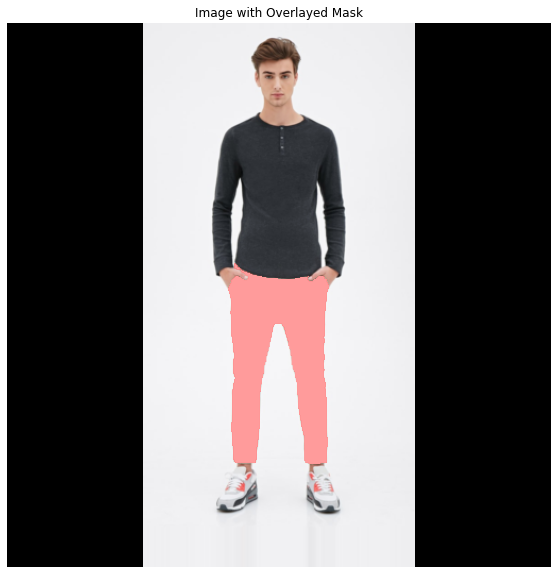

Caption Token IDs: tensor([49406,  7050,  1538,  7048,  5003, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])


In [18]:
# Get a batch
batch = next(iter(train_dataloader))

# Select the first image and mask from batch
img_tensor = batch['pixel_values'][0]
mask_tensor = batch['pixel_mask_values'][0]

# Unnormalize image tensor and convert to PIL
img_pil = TF.to_pil_image((img_tensor * 0.5 + 0.5).clamp(0, 1))

# Convert mask to a binary mask image (0 or 255)
mask_pil = TF.to_pil_image(mask_tensor).convert("L")  # "L" mode for grayscale

# Optionally: apply a color to the mask
mask_colored = Image.new("RGBA", mask_pil.size, color=(255, 0, 0, 100))  # Red with alpha
mask_binary = mask_pil.point(lambda x: 255 if x > 0 else 0).convert("1")  # binary mask

# Paste the red mask over the image using binary mask as alpha mask
img_overlay = img_pil.convert("RGBA").copy()
img_overlay.paste(mask_colored, mask=mask_binary)

# Display overlay
plt.figure(figsize=(10, 10))
plt.imshow(img_overlay)
plt.title("Image with Overlayed Mask")
plt.axis('off')
plt.show()

# Optional: print caption token IDs
print("Caption Token IDs:", batch['input_ids'][0])

# Optimizer and Scheduler

Using the default "constant" scheduler

In [19]:
# set up optimizer for the unet model
optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

In [20]:
# number of steps for training
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)

if max_train_steps is None:
    max_train_steps = num_train_epochs * num_update_steps_per_epoch

In [22]:
# create learning rate scheduler
lr_scheduler = get_constant_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=lr_warmup_steps * gradient_accumulation_steps, 
#     num_training_steps=max_train_steps * gradient_accumulation_steps
)

In [23]:
# display training info
print(f"  Num examples = {len(train_dataset)}")
print(f"  Num epochs = {num_train_epochs}")
print(f"  Batch size per device = {train_batch_size}")
print(f"  Gradient accumulation steps = {gradient_accumulation_steps}")
print(f"  Total optimization steps = {max_train_steps}")

  Num examples = 21377
  Num epochs = 10
  Batch size per device = 4
  Gradient accumulation steps = 1
  Total optimization steps = 53450


# Training Loop

Didn't understand the gradient accumulation part

In [24]:
global_step = 0

for epoch in range(num_train_epochs):
    print(f"\nEpoch {epoch+1}/{num_train_epochs}")
    unet.train()
    train_loss = 0.0
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        # move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # convert images to latent space using vae
        latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        
        # encode the masked images
        masked_latents = vae.encode(batch["masked_pixel_values"]).latent_dist.sample()
        masked_latents = masked_latents * vae.config.scaling_factor
        
        # resize mask to match latent resolution
        mask = F.interpolate(
            batch["pixel_mask_values"],
            size=(resolution // 8, resolution // 16),  # Match aspect ratio
            mode='nearest'
        )
        
        # sample noise for diffusion
        noise = torch.randn_like(latents)
        
        # sample random timesteps for diffusion process
        bsz = latents.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device
        ).long()
        
        # add noise to latents according to noise schedule (forward diffusion)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
        
        # concatenate the inputs for the unet
        latent_model_input = torch.cat([noisy_latents, mask, masked_latents], dim=1)
        
        # get text embeddings for conditioning
        encoder_hidden_states = text_encoder(batch["input_ids"])[0]
        
        # determine the target for loss calculation based on prediction type
        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise  # predict the noise that was added
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
        
        # forward pass through unet to predict noise
        model_pred = unet(
            latent_model_input, 
            timesteps, 
            encoder_hidden_states
        ).sample
        
        # calculate loss between prediction and target
        loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
        
        # calculate average loss for logging
        avg_loss = loss.item()
        train_loss += avg_loss / gradient_accumulation_steps
        
        # backward pass
        loss.backward()
        
        # gradient accumulation
        if (step + 1) % gradient_accumulation_steps == 0:
            # clip gradients
            torch.nn.utils.clip_grad_norm_(unet.parameters(), max_grad_norm)
            
            # optimizer step
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
            # increment global step and log progress
            global_step += 1
            
            # log the loss
            if global_step % 10 == 0:
                print(f"Step {global_step}: Loss: {train_loss:.5f}")
                train_loss = 0.0
            
            # save checkpoint
            if global_step % checkpointing_steps == 0:
                print(f"Saving checkpoint at step {global_step}")
                save_path = os.path.join(output_dir, f"checkpoint-{global_step}")
                os.makedirs(save_path, exist_ok=True)
                
                # save the unet model
                unet.save_pretrained(os.path.join(save_path, "unet"))
                
                print(f"Saved checkpoint to {save_path}")
            
        # check if we've reached max steps
        if global_step >= max_train_steps:
            break
    
    # end of epoch
    print(f"Epoch {epoch+1} finished")
    
    # check if we've reached max steps
    if global_step >= max_train_steps:
        break

# end of training - save the final model
print("Training complete!")
print(f"Saving final model to {output_dir}")

# save the final unet
unet.save_pretrained(os.path.join(output_dir, "unet"))

# create and save the full pipeline for inference
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
)

# save the pipeline
pipeline.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")


Epoch 1/10


Training:   0%|          | 0/5345 [00:00<?, ?it/s]

/home/eqp6pg/.conda/envs/my-torch/lib/python3.8/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 32 for tensor number 1 in the list.

In [ ]:
feature_extractor
safety_checker
scheduler
text_encoder
tokenizer
unet
vae

feature_extractor
safety_checker
scheduler
text_encoder
tokenizer
unet
vae